In [1]:
import numpy as np
import pints
import pints.plot
import pints_smol_moments_4_normalised_jit as toy
import matplotlib.pyplot as plt
from scipy.stats import moment
import pandas as pd



Select the desired model, true parameters and time array.

Then simulate to get synthetic data

In [2]:

model = toy.SmolModel(None,None)


true_parameters = [0.0003, 900]


times = np.linspace(20, 75, 56)

df = pd.read_csv('2017-03-16_inference_input_multi_well_t_20.csv', header=None)
org_values = np.transpose(df.to_numpy())
org_values = org_values[:56,:]


# 1st moment is mean, 1st centred moment should be array 6
centred_moment_1 = moment(org_values, moment=1, axis=1)
centred_moment_2 = moment(org_values, moment=2, axis=1)
centred_moment_3 = moment(org_values, moment=3, axis=1)
centred_moment_4 = moment(org_values, moment=4, axis=1)

# Out array, mean, variance then centred standardised moments (aka skewness, kurtosis, hyperskewness)
st_dev = np.sqrt(centred_moment_2)
out_array = np.zeros((56,4))
out_array[:,0] = np.mean(org_values,axis=1)
out_array[:,1] = centred_moment_2
out_array[:,2] = np.divide(centred_moment_3,st_dev*st_dev*st_dev)
out_array[:,3] = np.divide(centred_moment_4,st_dev*st_dev*st_dev*st_dev)

# print(st_dev)

# print(np.mean(org_values, axis=1))
# print(centred_moment_3)



Add noise to the data (using random sampling from normal distribution)

In [3]:

# noise = 9
# values = org_values + np.random.normal(0, noise, org_values.shape)

size_noise = 4
noise_value = 1
# # Create a list with the specified size filled with a placeholder value
noise_arr = [noise_value for _ in range(size_noise)]
# noise_arr[0] = 1
# noise_arr[1] = 1
# noise_arr[2] = 1
# noise_arr[3] = 1


Set-up pints problem and log likelihoods

In [4]:

# problem = pints.MultiOutputProblem(model, times, centred_moments)
problem = pints.MultiOutputProblem(model, times, out_array)

log_likelihood = pints.GaussianLogLikelihood(problem)
# log_likelihood_2 = pints.GaussianIntegratedLogUniformLogLikelihood(problem)

print('Original problem dimension: ' + str(problem.n_parameters()))
print('New dimension: ' + str(log_likelihood.n_parameters()))
# print('New dimension: ' + str(log_likelihood_2.n_parameters()))

true_parameters += noise_arr
# print(true_parameters)



Original problem dimension: 2
New dimension: 6


Create uniform log prior

In [5]:

# Define the size of the list
size = 6
placeholder_lower_value = 0
placeholder_upper_value = 1000
 
# Create a list with the specified size filled with a placeholder value
prior_arr_lower = [placeholder_lower_value for _ in range(size)]
prior_arr_upper = [placeholder_upper_value for _ in range(size)]
prior_arr_lower[0] = 0.00001
prior_arr_upper[0] = 0.001
prior_arr_lower[1] = 1
prior_arr_upper[1] = 4000
prior_arr_lower[2] = 0
prior_arr_upper[2] = 100
prior_arr_lower[3] = 0
prior_arr_upper[3] = 100
prior_arr_lower[4] = 0
prior_arr_upper[4] = 100
prior_arr_lower[5] = 0
prior_arr_upper[5] = 100


# log_prior = pints.UniformLogPrior(
#     [0.000001, 1, 1],
#     [0.01, 10000, 100]
#     )
log_prior = pints.UniformLogPrior(
    prior_arr_lower,
    prior_arr_upper
    )

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)


/var/folders/lt/9g_w308946v4x_5mqxc951qr0000gr/T/ipykernel_2916/152966210.py:27: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior(


In [6]:

xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]
ITERS = 1000
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.SliceDoublingMCMC)
mcmc.set_max_iterations(ITERS)
chains = mcmc.run()
print(chains)



Using Slice Sampling - Doubling
Generating 3 chains.
Running in sequential mode.


Iter. Eval. Time m:s
0     3       0:00.3
1     435     0:01.3
2     837     0:02.2
3     1236    0:03.2
20    7206    0:17.1
40    12309   0:29.3
60    17031   0:40.5
80    21810   0:51.7
100   27117   1:04.2
120   32136   1:15.9
140   36963   1:27.4
160   42057   1:39.4
180   47178   1:51.5
200   52077   2:03.0
220   56934   2:14.4
240   61650   2:25.5
260   66585   2:37.1
280   71688   2:49.1
300   76470   3:00.5
320   81396   3:12.0
340   86421   3:23.7
360   91674   3:36.0
380   96810   3:48.1
400   102012   4:00.1
420   106734   4:11.2
440   111900   4:23.3
460   116637   4:34.5
480   121965   4:46.8
500   127134   4:59.0
520   132198   5:10.8
540   137490   5:23.2
560   142848   5:35.8
580   147969   5:47.7
600   152889   5:59.3
620   157839   6:10.9
640   163032   6:23.0
660   168186   6:35.0
680   173304   6:47.5
700   178320   6:59.2
720   183471   7:11.0
740   188673   7:23.2
760   193794   7:35.1
780   198912   7:47.1
800   204084   7:59.2
820   209043   8:10.9
840   213912

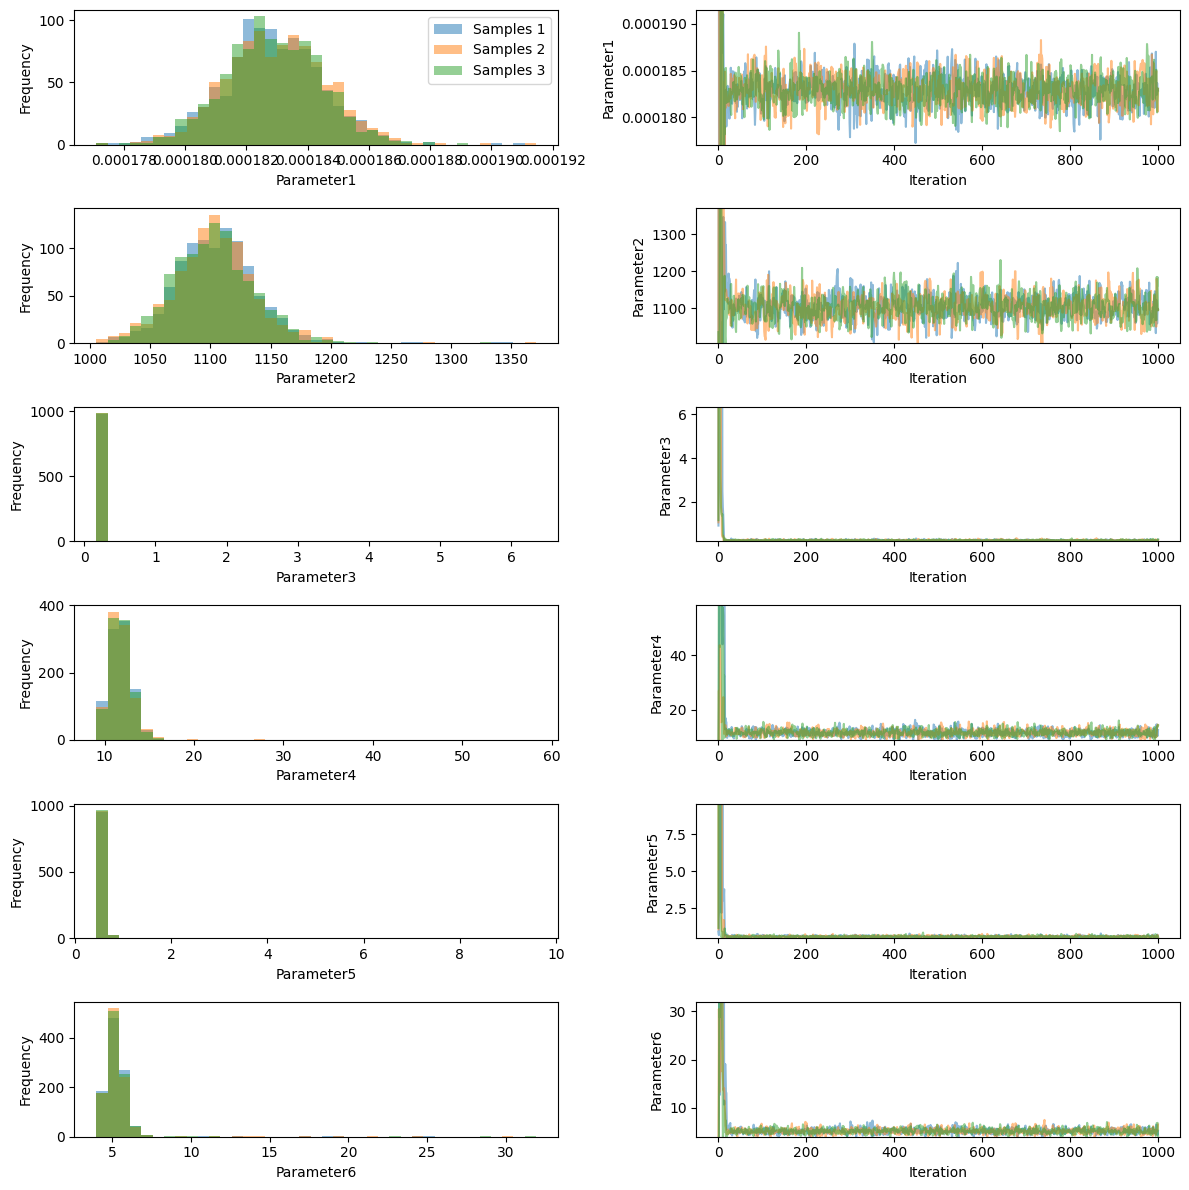

In [7]:

pints.plot.trace(chains, n_percentiles=99)
plt.savefig("mcmc.png")
plt.show()


In [8]:

# ITERS = 100
AllChains = chains[0,200:1000,:]
# np.asarray(AllChains)
print(np.shape(AllChains))
print(AllChains[0])
print(AllChains)


(800, 6)
[1.82289822e-04 1.06622777e+03 2.00312007e-01 1.19900325e+01
 4.74494947e-01 5.28484766e+00]
[[1.82289822e-04 1.06622777e+03 2.00312007e-01 1.19900325e+01
  4.74494947e-01 5.28484766e+00]
 [1.84188084e-04 1.12148181e+03 2.16142113e-01 1.16139747e+01
  5.44094308e-01 6.31169712e+00]
 [1.81630800e-04 1.10059001e+03 2.35697616e-01 1.36835624e+01
  5.70229567e-01 5.12187629e+00]
 ...
 [1.83673081e-04 1.05834118e+03 2.15660177e-01 1.09796794e+01
  6.96289380e-01 4.68465188e+00]
 [1.83007867e-04 1.09614616e+03 1.84012928e-01 1.04830027e+01
  6.56504197e-01 4.36856807e+00]
 [1.82857139e-04 1.09682036e+03 2.55368817e-01 1.26882560e+01
  4.97374507e-01 5.23690447e+00]]


In [9]:

for I in range(3-1):
    AllChains_add = chains[I+1,200:1000,:]
    AllChains = np.concatenate((AllChains,AllChains_add), axis=0)


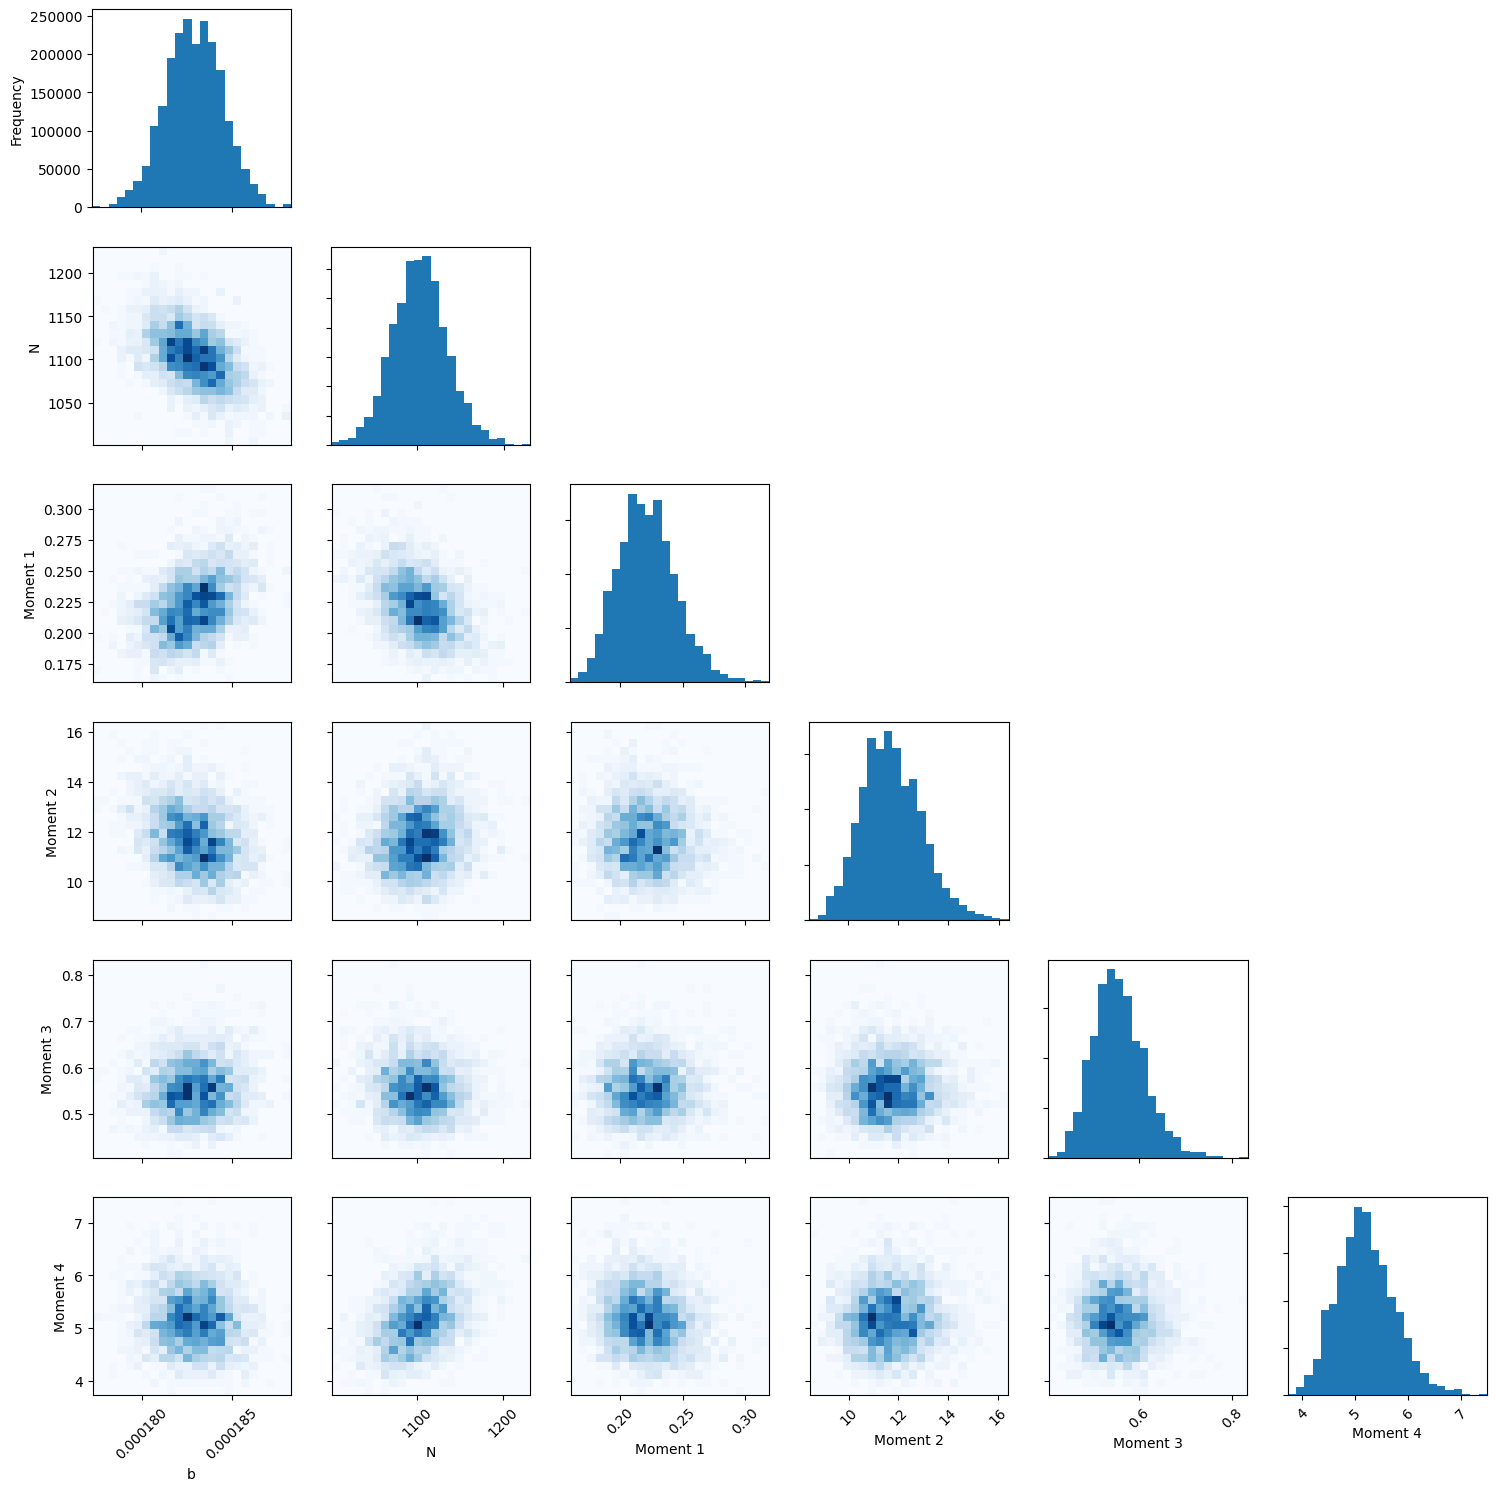

In [10]:


parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"])
plt.show()

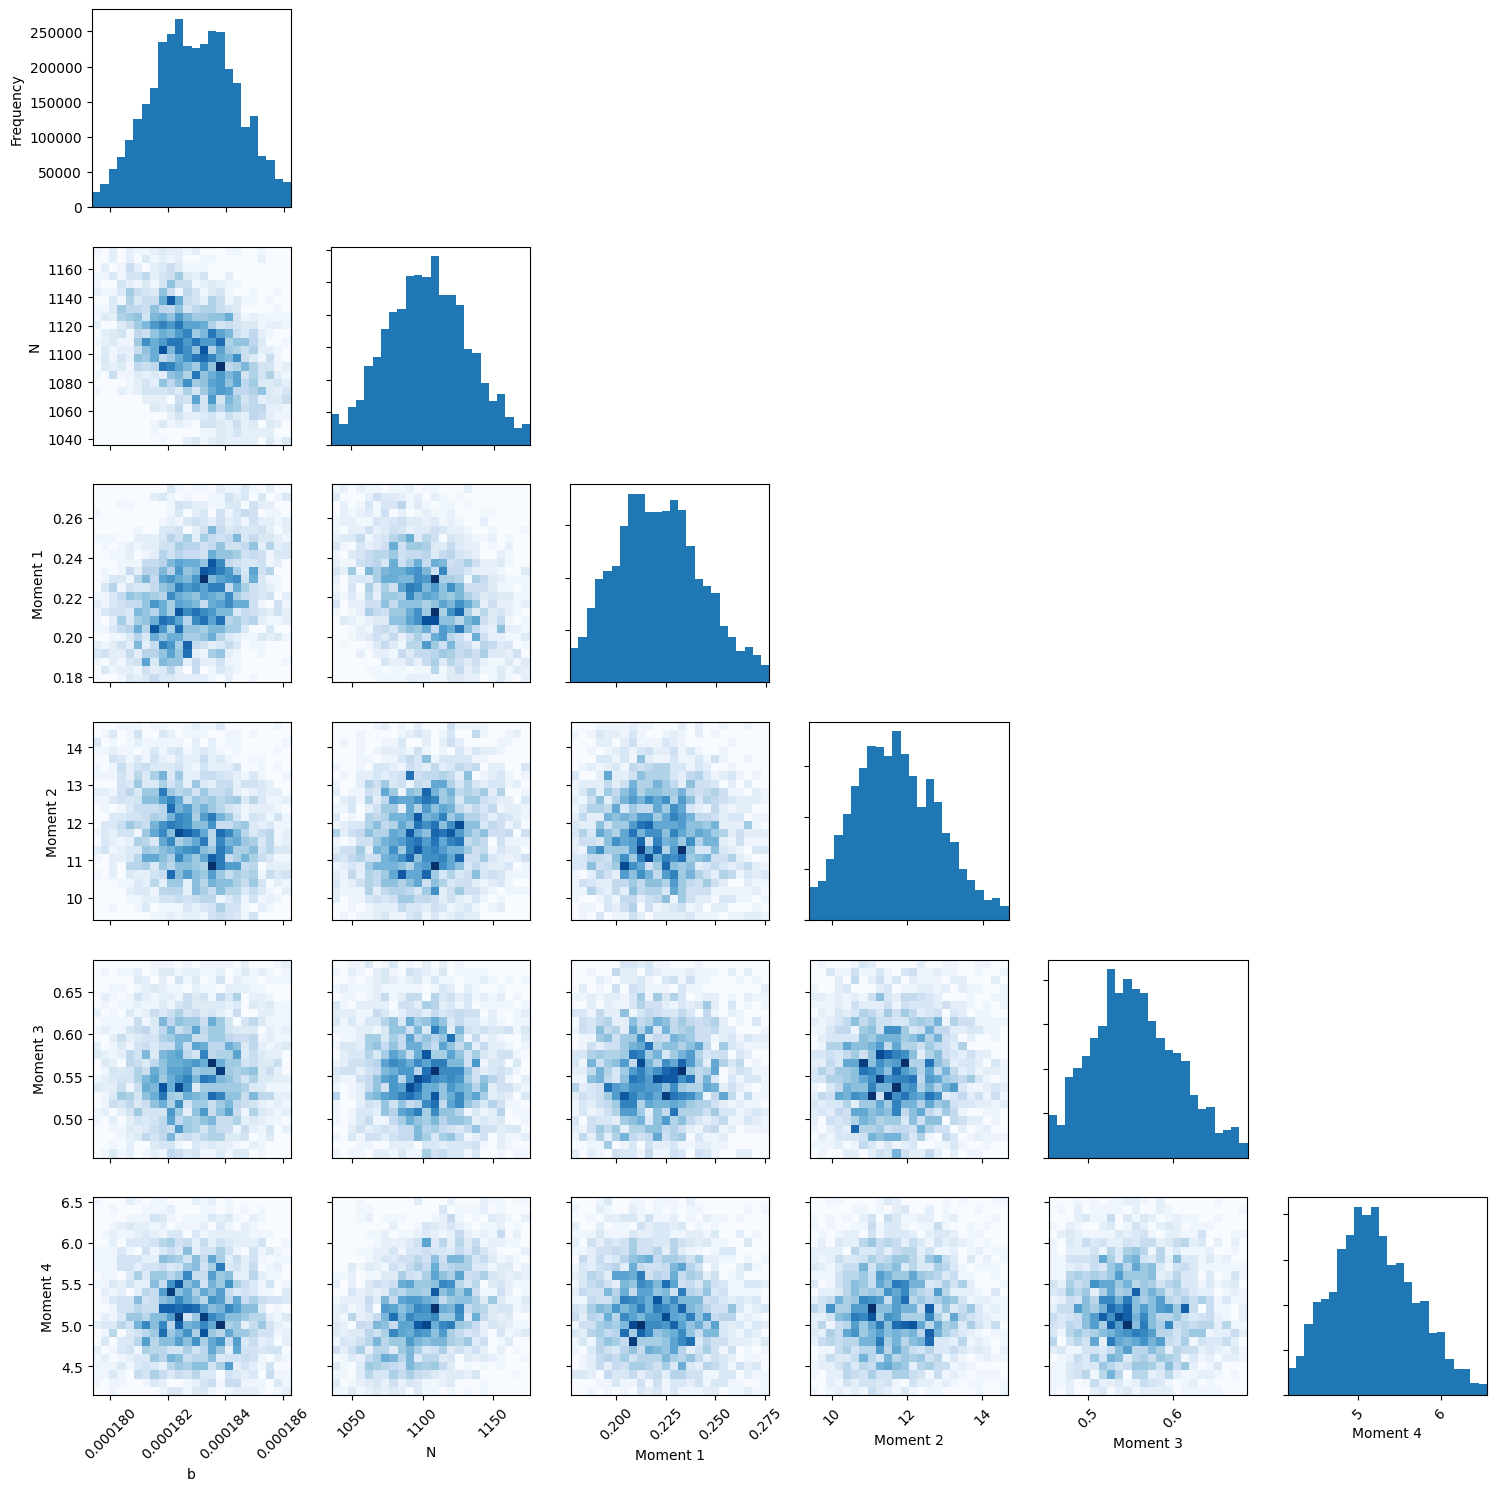

In [11]:
parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"],
                    n_percentiles=97)
                    
plt.show()

[1.82289822e-04 1.06622777e+03 2.00312007e-01 1.19900325e+01
 4.74494947e-01 5.28484766e+00]


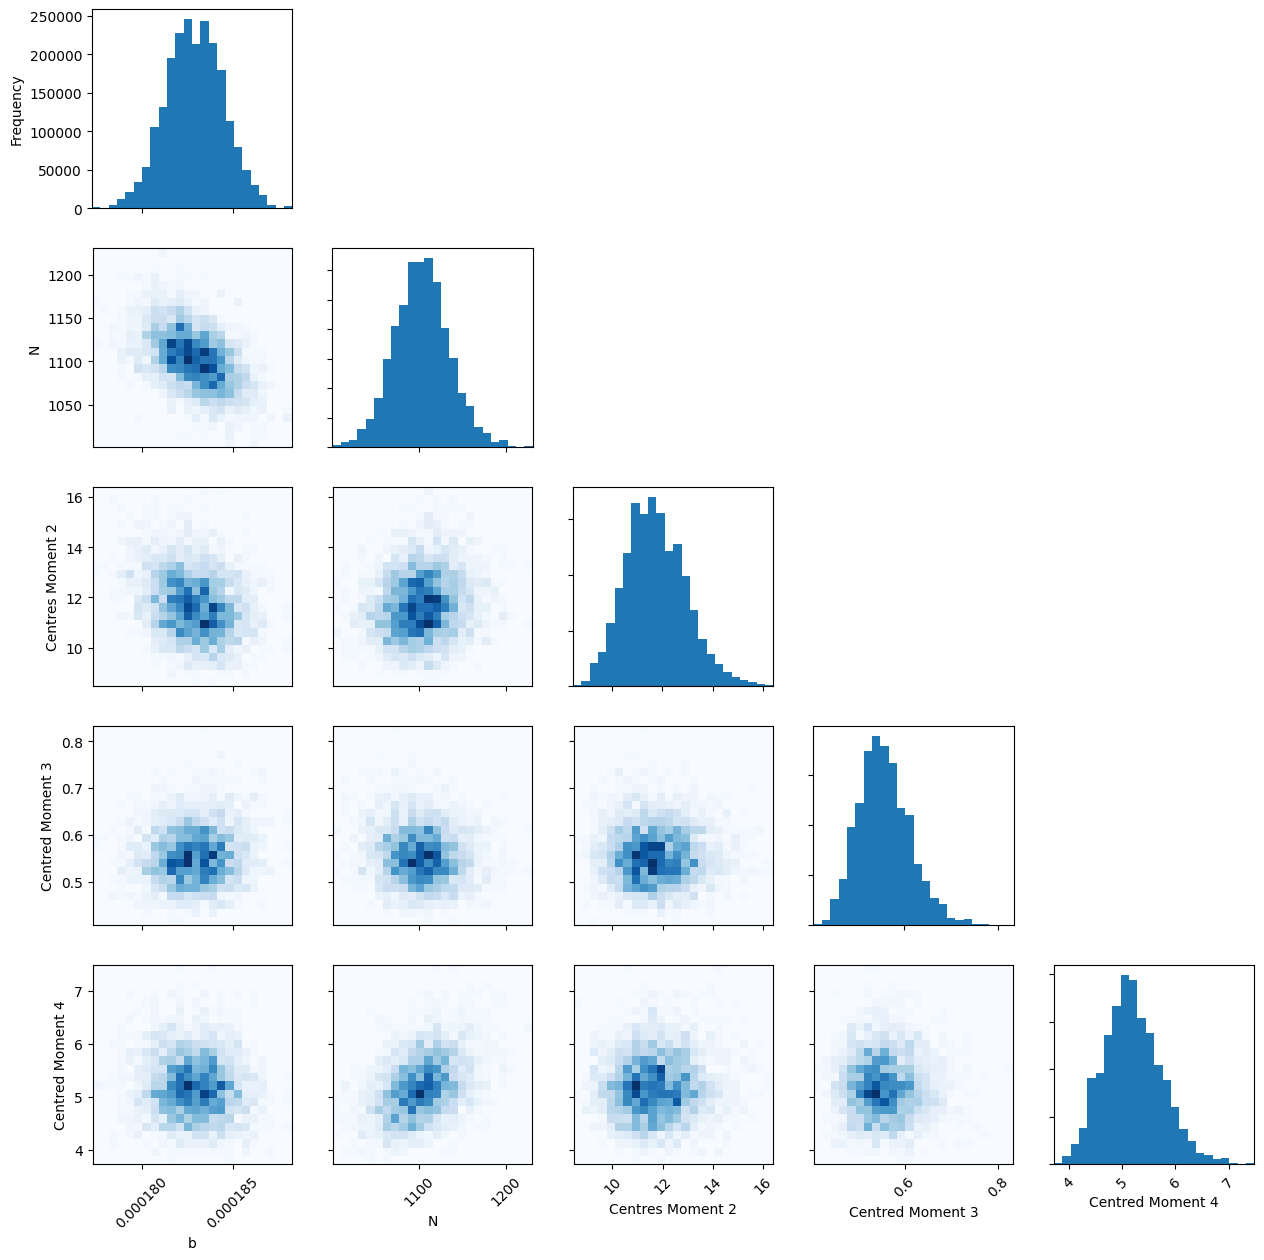

In [12]:
parameter_names = ["b","N", "Moment 2", "Moment 3", "Moment 4"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)
print(AllChains[0])
pints.plot.pairwise(AllChains[:,[0,1,3,4,5]], heatmap=True, 
                    parameter_names=["b","N", "Centres Moment 2", "Centred Moment 3", "Centred Moment 4"])
plt.savefig("Pints_pairwise.png", dpi =300)
plt.show()


In [13]:
parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
results = pints.MCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)


<class 'pints._mcmc._summary.MCMCSummary'>
param     mean     std.    2.5%     25%      50%      75%      97.5%    rhat    ess     ess per sec.
--------  -------  ------  -------  -------  -------  -------  -------  ------  ------  --------------
b         0.00     0.00    0.00     0.00     0.00     0.00     0.00     1.00    357.95  0.62
N         1103.99  31.27   1041.17  1082.78  1104.01  1123.56  1169.30  1.00    335.98  0.58
Moment 1  0.22     0.02    0.18     0.20     0.22     0.24     0.27     1.00    410.60  0.71
Moment 2  11.75    1.22    9.57     10.89    11.66    12.58    14.39    1.00    450.82  0.78
Moment 3  0.56     0.06    0.46     0.52     0.55     0.59     0.68     1.00    478.50  0.82
Moment 4  5.20     0.55    4.25     4.83     5.16     5.55     6.37     1.00    429.32  0.74


In [14]:
from tabulate import tabulate
class MyMCMCSummary(pints.MCMCSummary):
    def __str__(self):
        """
        Prints posterior summaries for all parameters to the console, including
        the parameter name, posterior mean, posterior std deviation, the
        2.5%, 25%, 50%, 75% and 97.5% posterior quantiles, rhat, effective
        sample size (ess) and ess per second of run time.
        """
        if self._summary_str is None:
            headers = [
                'param', 'mean', 'std.',
                '2.5%', '25%', '50%', '75%', '97.5%',
                'rhat', 'ess']
            if self._time is not None:
                headers.append('ess per sec.')

            self._summary_str = tabulate(
                self._summary_list,
                headers=headers,
                numalign='left',
                floatfmt='.3g',
            )

        return self._summary_str
    


In [15]:

parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
results = MyMCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)

<class '__main__.MyMCMCSummary'>
param     mean      std.      2.5%      25%       50%       75%       97.5%     rhat    ess    ess per sec.
--------  --------  --------  --------  --------  --------  --------  --------  ------  -----  --------------
b         0.000183  1.56e-06  0.00018   0.000182  0.000183  0.000184  0.000186  1       358    0.617
N         1.1e+03   31.3      1.04e+03  1.08e+03  1.1e+03   1.12e+03  1.17e+03  1       336    0.579
Moment 1  0.221     0.0234    0.181     0.204     0.22      0.236     0.271     1       411    0.707
Moment 2  11.8      1.22      9.57      10.9      11.7      12.6      14.4      1       451    0.777
Moment 3  0.556     0.0558    0.457     0.518     0.551     0.592     0.676     0.999   478    0.824
Moment 4  5.2       0.546     4.25      4.83      5.16      5.55      6.37      1       429    0.74


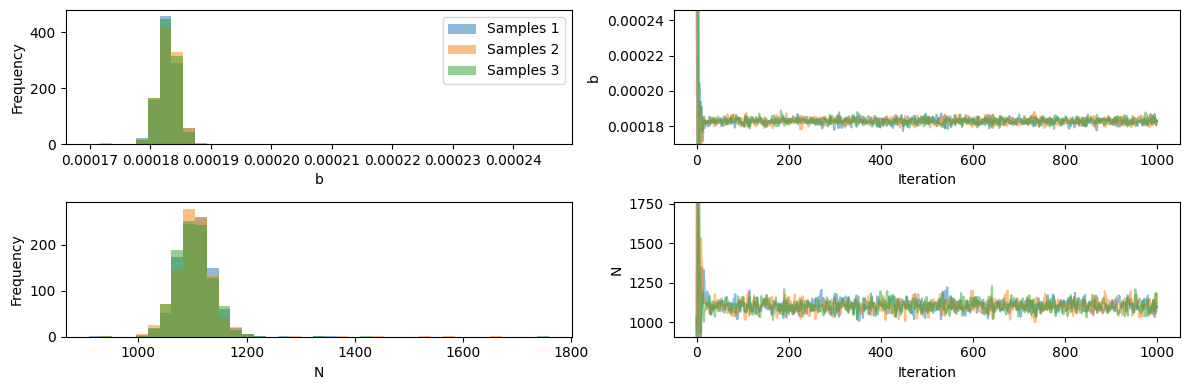

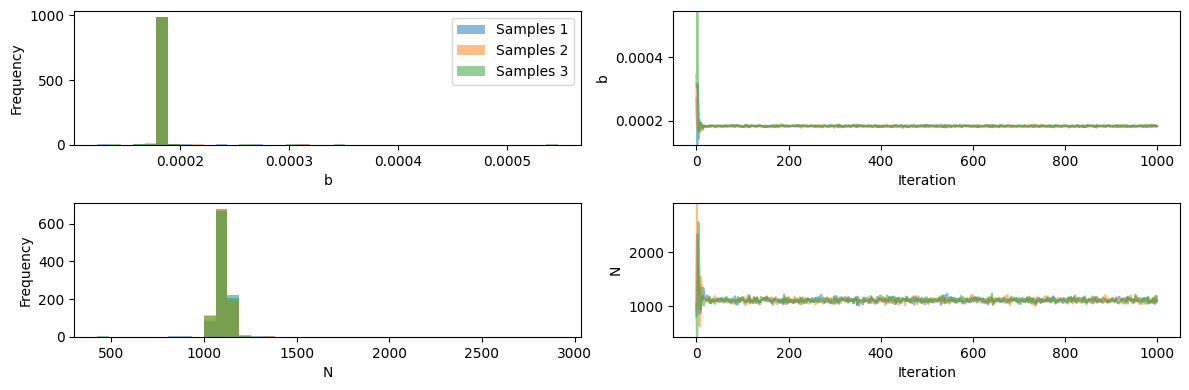

In [16]:
pints.plot.trace(chains[:,:,[0,1]], n_percentiles=99.5, parameter_names=["b","N"])
plt.savefig("pints_out_extremes_removed.png", dpi=300)
plt.show()
pints.plot.trace(chains[:,:,[0,1]], parameter_names=["b","N"])
plt.savefig("pints_out.png", dpi=300)
plt.show()

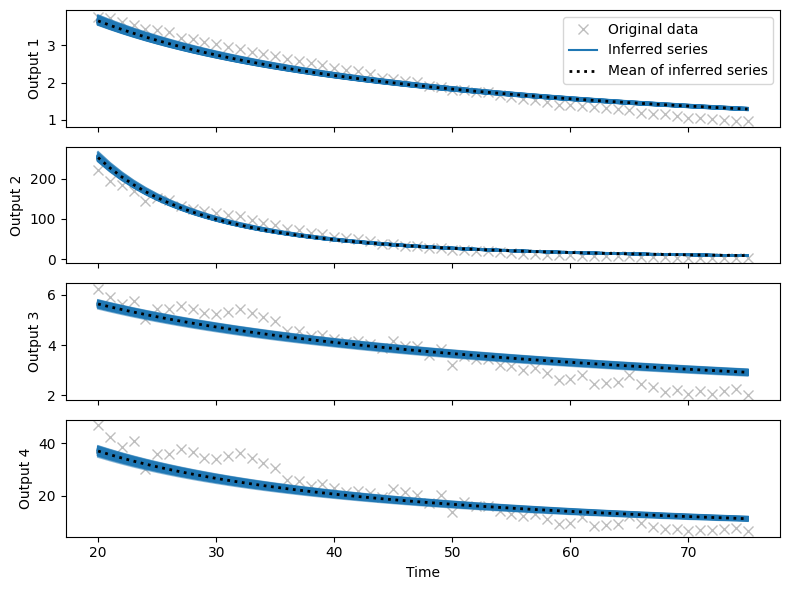

In [17]:
fig, axes = pints.plot.series(AllChains, problem)

# # Customise the plot, and add the original, noise-free data
# fig.set_size_inches(12,4.5)
# plt.plot(times, org_values, c='orange', label='Noise-free data')
# plt.legend()
# plt.show()

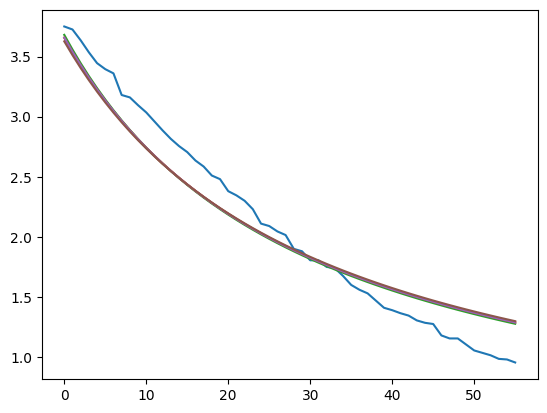

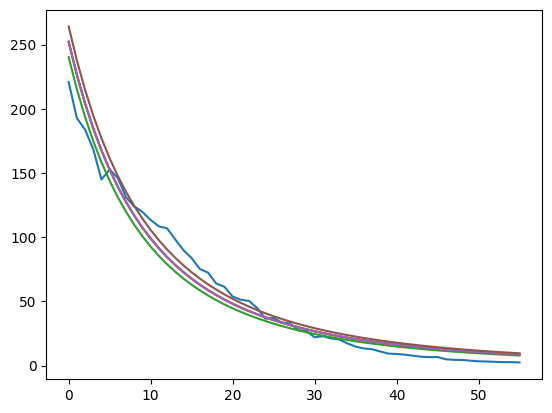

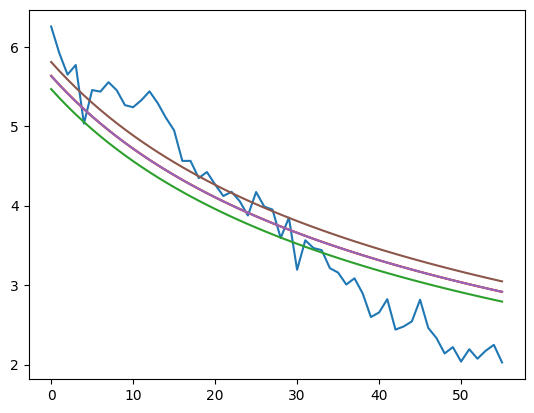

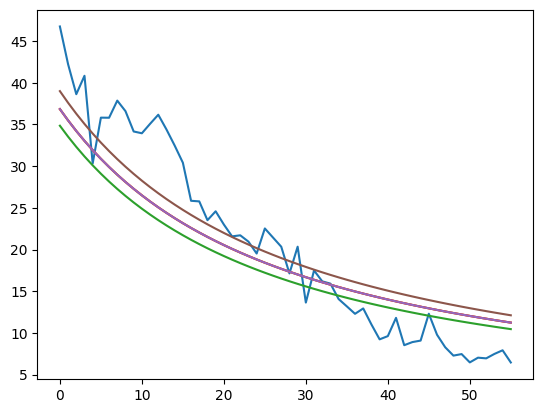

In [18]:

data_mean = out_array[:,0]
data_variance = out_array[:,1]
data_skewness = out_array[:,2]
data_kurtosis = out_array[:,3]

# for i in range(1000):
means = results.mean()[[0,1]]
st_devs = results.std()[[0,1]]

CI_0 = means

CI_1 = means + 2*st_devs

CI_2 = means
CI_2[0] += 2*st_devs[0]
CI_2[1] -= 2*st_devs[1] 

CI_3 = means
CI_3[0] -= 2*st_devs[0]
CI_3[1] += 2*st_devs[1] 

CI_4 = means - 2*st_devs

values_0 = model.simulate(CI_0, times)
values_1 = model.simulate(CI_1, times)
values_2 = model.simulate(CI_2, times)
values_3 = model.simulate(CI_3, times)
values_4 = model.simulate(CI_4, times)
# print(np.shape(values))

plt.plot(data_mean)
plt.plot(values_0[:,0])
plt.plot(values_1[:,0])
plt.plot(values_2[:,0])
plt.plot(values_3[:,0])
plt.plot(values_4[:,0])
plt.show()



plt.plot(data_variance)
plt.plot(values_0[:,1])
plt.plot(values_1[:,1])
plt.plot(values_2[:,1])
plt.plot(values_3[:,1])
plt.plot(values_4[:,1])
plt.show()


plt.plot(data_skewness)
plt.plot(values_0[:,2])
plt.plot(values_1[:,2])
plt.plot(values_2[:,2])
plt.plot(values_3[:,2])
plt.plot(values_4[:,2])
plt.show()

plt.plot(data_kurtosis)
plt.plot(values_0[:,3])
plt.plot(values_1[:,3])
plt.plot(values_2[:,3])
plt.plot(values_3[:,3])
plt.plot(values_4[:,3])
plt.show()

ValueError: x and y must have same first dimension, but have shapes (71,) and (56,)

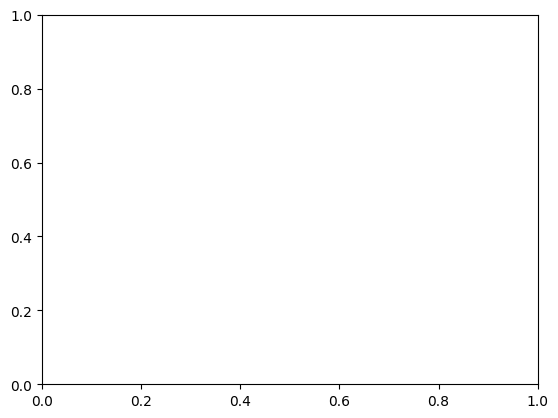

In [19]:

data_mean = out_array[:,0]
data_variance = out_array[:,1]
data_skewness = out_array[:,2]
data_kurtosis = out_array[:,3]

# for i in range(1000):
means = results.mean()[[0,1]]
st_devs = results.std()[[0,1]]

mean_CI = results.mean()[[2,3,4,5]]
st_devs_CI = results.std()[[2,3,4,5]]

CI_0 = means


values_0 = model.simulate(CI_0, times)
x=np.linspace(20,90,56)

y1=values_0[:,0]+mean_CI[0]+2*st_devs_CI[0]
y2=values_0[:,0]-mean_CI[0]-2*st_devs_CI[0]
plt.plot(x,y1)
plt.plot(x,y2)
plt.fill_between(x,y1,y2)
plt.plot(x,data_mean)
plt.plot(x,values_0[:,0])
plt.show()

y1=values_0[:,1]+mean_CI[1]+2*st_devs_CI[1]
y2=values_0[:,1]-mean_CI[1]-2*st_devs_CI[1]
plt.plot(x,y1)
plt.plot(x,y2)
plt.fill_between(x,y1,y2)
plt.plot(x,data_variance)
plt.plot(x,values_0[:,1])
plt.show()

y1=values_0[:,2]+mean_CI[2]+2*st_devs_CI[2]
y2=values_0[:,2]-mean_CI[2]-2*st_devs_CI[2]
plt.plot(x,y1)
plt.plot(x,y2)
plt.fill_between(x,y1,y2)
plt.plot(x,data_skewness)
plt.plot(x,values_0[:,2])
plt.show()


y1=values_0[:,3]+mean_CI[3]+2*st_devs_CI[3]
y2=values_0[:,3]-mean_CI[3]-2*st_devs_CI[3]
plt.plot(x,y1)
plt.plot(x,y2)
plt.fill_between(x,y1,y2)
plt.plot(x,data_kurtosis)
plt.plot(x,values_0[:,3])
plt.show()
